In [1]:
import numpy as np
import pystan
from data_pertub import *
from mcmc_plot import *
from PPCA_pystan import *
import warnings
from PPCA_pystan import *
warnings.filterwarnings("ignore")

## 1. Generate Data

In [2]:
config = configparser.ConfigParser()
config.sections()
# for i in os.listdir('param2/'):
config.read("10000.ini")
data_config = dict(config['data_config'])


In [3]:
n_sample = int(data_config['n_sample'])
alpha = float(data_config['alpha'])


d = int(data_config['d'])
q_star = int(data_config['q_star'])
a_vj = float(data_config['a_vj']) * np.ones(q_star)
epsilon = float(data_config['epsilon'])
beta_vj = epsilon * (a_vj - 1)
beta_sigma2 = float(data_config['beta_sigma2'])
a_sigma2 = float(data_config['a_sigma2'])

prior_param_true = dict({'beta_sigma2': beta_sigma2,
                    'a_sigma2': a_sigma2,
                    'a_vj': a_vj,
                    'beta_vj': beta_vj
                    })

y_true, W_star, Z_star, sigma2_star, v_star_list = forward_sample(d, q_star, n_sample, prior_param_true, verbose = True)
y_perturbation = sample_perturbation2(y_true, n_sample, alpha)

true sigma2_star is 0.009702470877229528
true v_j list is [0.15893098]


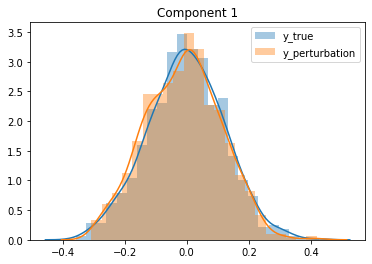

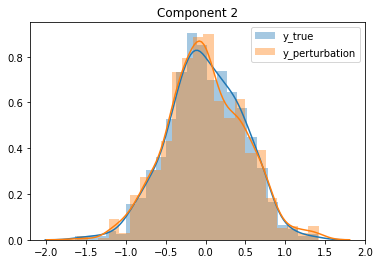

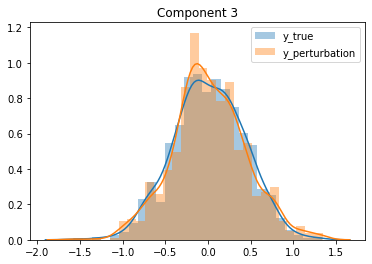

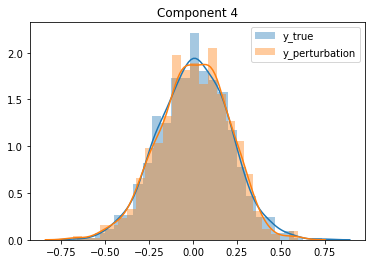

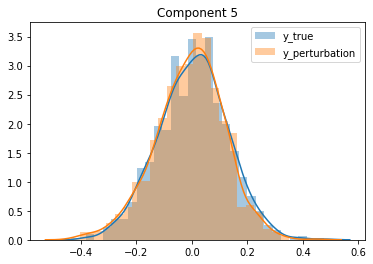

In [4]:
for j in range(d):    
    sns.distplot(y_true[j,:], label='y_true')
    sns.distplot(y_perturbation[j,:], label='y_perturbation')
    plt.legend()
    plt.title('Component '+ str(j+1))
    plt.show()
    
X = y_true

## 2. MCMC Prior and Starting Point


In [5]:
config = configparser.ConfigParser()
config.sections()
# for i in os.listdir('param2/'):
config.read("10000.ini")
mcmc_setup = dict(config['mcmc_setup'])

In [6]:
# inference parameter
d = int(data_config['d'])
q = int(mcmc_setup['q'])
xi = float(mcmc_setup['xi'])


# prior parameter
beta_sigma2 = float(mcmc_setup['beta_sigma2'])
a_sigma2 = float(mcmc_setup['a_sigma2'])
a_vj = float(mcmc_setup['a_vj']) * np.ones(q)
epsilon = float(mcmc_setup['epsilon'])
beta_vj = epsilon * (a_vj - 1)


# sampling parameter
prior_param_mcmc = dict({'beta_sigma2': beta_sigma2,
                    'a_sigma2': a_sigma2,
                    'a_vj': a_vj,
                    'beta_vj': beta_vj
                    })


In [7]:
n_chains = int(mcmc_setup['n_chains'])
iterations = int(mcmc_setup['iterations'])

In [8]:
sm = pystan.StanModel(model_code = ppca_code) # code compile

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_130ec30cd3f8b556c43132607603c6cf NOW.


In [9]:
init_list=[]
for i_ in range(n_chains):
    temp_dict={
        'v': 1/np.random.gamma(a_vj, 1/ beta_vj),
        'sigma2': 1/np.random.gamma(a_sigma2, 1/beta_sigma2),
        "w0": np.random.normal(0, 1, [q, d])
    }
    init_list.append(temp_dict)

In [10]:
init_list=[]
for i_ in range(n_chains):
    temp_dict={
        #'v': np.repeat(v_star_list, q).ravel(),
#        'v': sorted(v_star_list),
        'v': sorted(1/np.random.gamma(a_vj, 1/ beta_vj)),
        'sigma2': sigma2_star,
        "w0": W_star.T
    }
    init_list.append(temp_dict)

## 3. MCMC Standard

In [11]:
print(sm.model_code)


data { 
    int D; //number of dimensions
    int N; //number of data
    int Q; //number of principle components
    vector[D] x[N]; //data
    real a_vj; // w_j prior 
    real epsilon;// w_j mean
    real xi; // power parameter
    real a_sigma2; // sigma2 prior 
    real beta_sigma2;// sigma2 mean
}

parameters {
    ordered[Q] v; // v_j
    real<lower=0> sigma2; //data sigma2
    matrix[Q,D] W; //projection matrix
}
model {
    matrix[D,D] C; //covaraince matrix
    for(j in 1:Q){
        v[j] ~ inv_gamma(a_vj, epsilon * (a_vj -1));
        W[j] ~ multi_normal(rep_vector(0,D), v[j] * diag_matrix(rep_vector(1, D)));
        }
        
    sigma2 ~ inv_gamma(a_sigma2, beta_sigma2);
    C = crossprod(W)+ sigma2 * diag_matrix(rep_vector(1, D));
    for(n in 1:N){
    target += xi * multi_normal_lpdf(x[n]|rep_vector(0,D), C);
    }
}

generated quantities {
    vector[D] y_hat[N]; //predictive
    for (n in 1:N) {
        y_hat[n] = multi_normal_rng(rep_vector(0,D), crossprod(W)+ sigm

In [12]:
ppca_dat_standard = {'D': d,
            'N': n_sample,
            'Q': q,
            'x': X.reshape([n_sample, d]),
            'xi': 1,
            'a_vj': a_vj[0],
            'epsilon': epsilon,
            'a_sigma2': a_sigma2,
            'beta_sigma2': beta_sigma2
                           }


In [13]:
fit_standard = sm.sampling(data = ppca_dat_standard, iter = iterations, chains = n_chains, init = init_list, seed =1)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### Posterior Predictive Check

In [14]:
y_hat = fit_standard.extract('y_hat')['y_hat'][0]

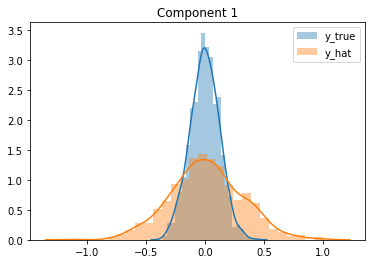

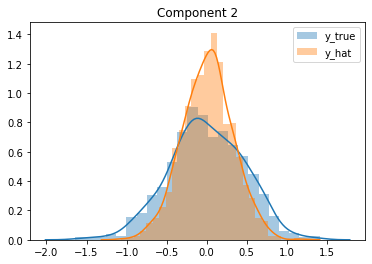

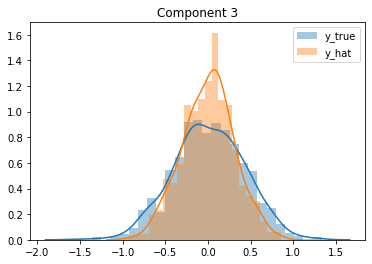

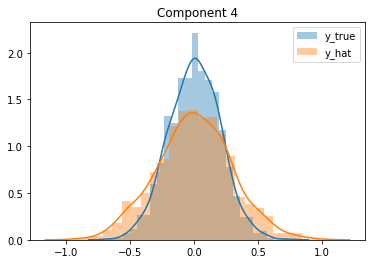

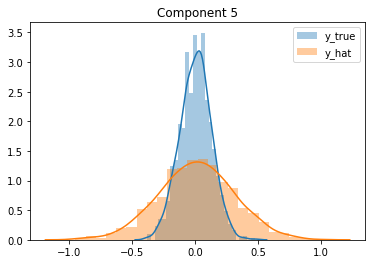

In [15]:
for j in range(d):    
    sns.distplot(y_true[j,:], label='y_true')
    sns.distplot(y_hat[:,j], label='y_hat')
    plt.legend()
    plt.title('Component '+ str(j+1))
    plt.show()
    

In [16]:
v_star_list

array([0.15893098])

In [17]:
sigma2_star

0.009702470877229528

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
v[0]    0.017  0.004   0.009    0.025      0.000    0.000    1242.0   967.0   
v[1]    0.022  0.006   0.013    0.033      0.000    0.000    1366.0  1179.0   
v[2]    0.028  0.008   0.016    0.044      0.000    0.000    1786.0  1647.0   
v[3]    0.042  0.017   0.017    0.070      0.000    0.000    2010.0  1793.0   
sigma2  0.077  0.003   0.072    0.082      0.000    0.000    1434.0  1434.0   
W[0,0] -0.003  0.067  -0.121    0.118      0.003    0.002     698.0   698.0   
W[0,1]  0.004  0.056  -0.093    0.108      0.002    0.002     606.0   606.0   
W[0,2]  0.004  0.084  -0.142    0.149      0.003    0.002     604.0   604.0   
W[0,3]  0.001  0.044  -0.081    0.081      0.002    0.001     799.0   799.0   
W[0,4]  0.002  0.060  -0.096    0.119      0.002    0.002     617.0   617.0   
W[1,0] -0.001  0.068  -0.122    0.117      0.003    0.002     564.0   564.0   
W[1,1]  0.002  0.056  -0.099    0.094      0.002    

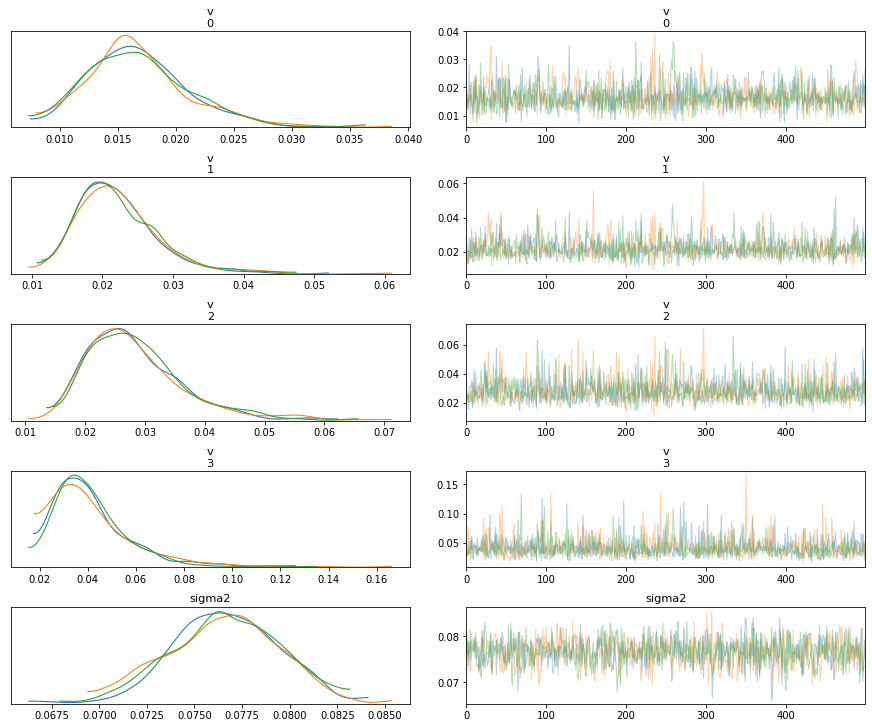

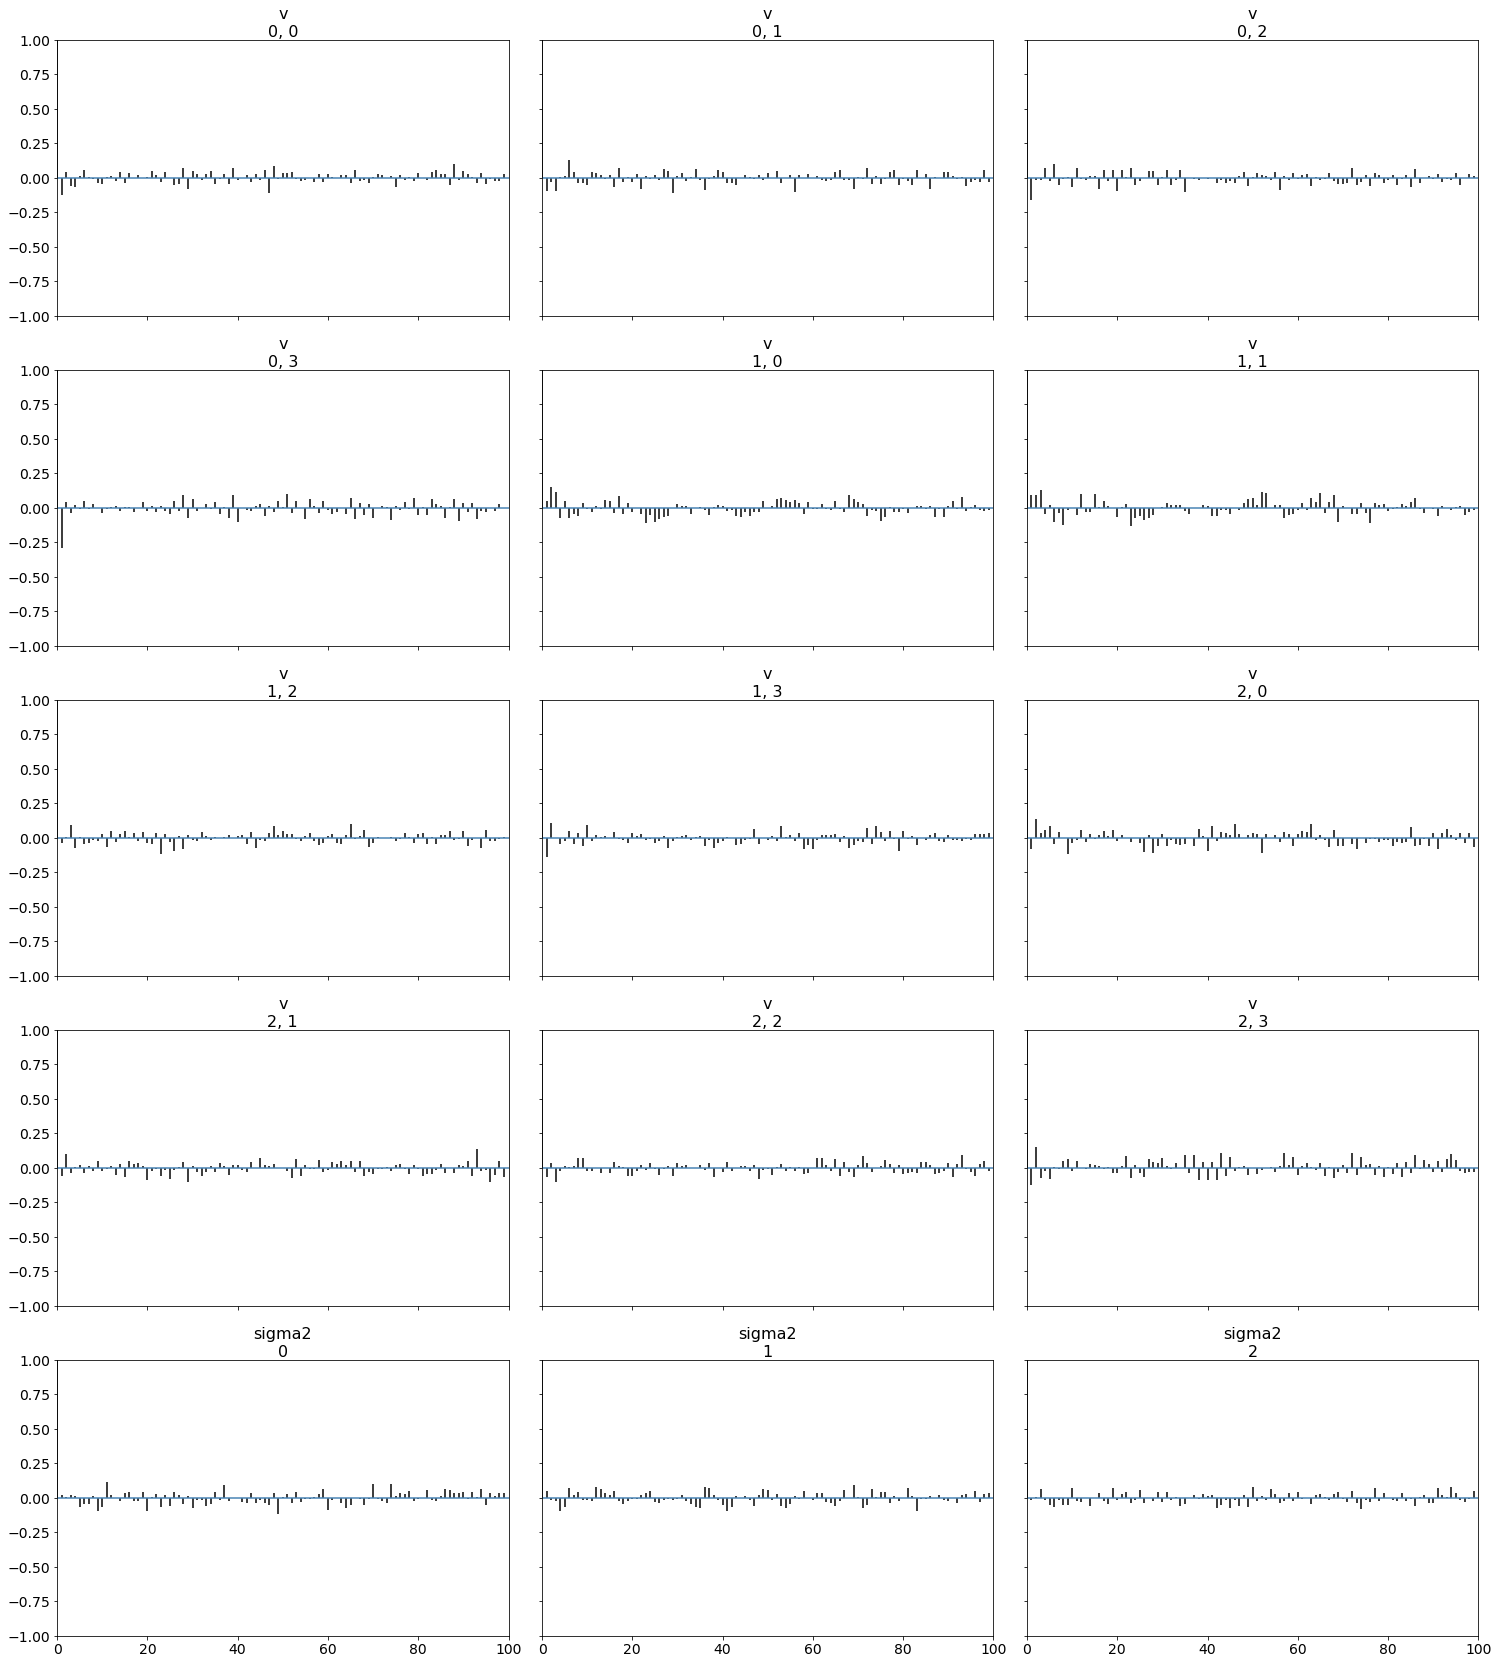

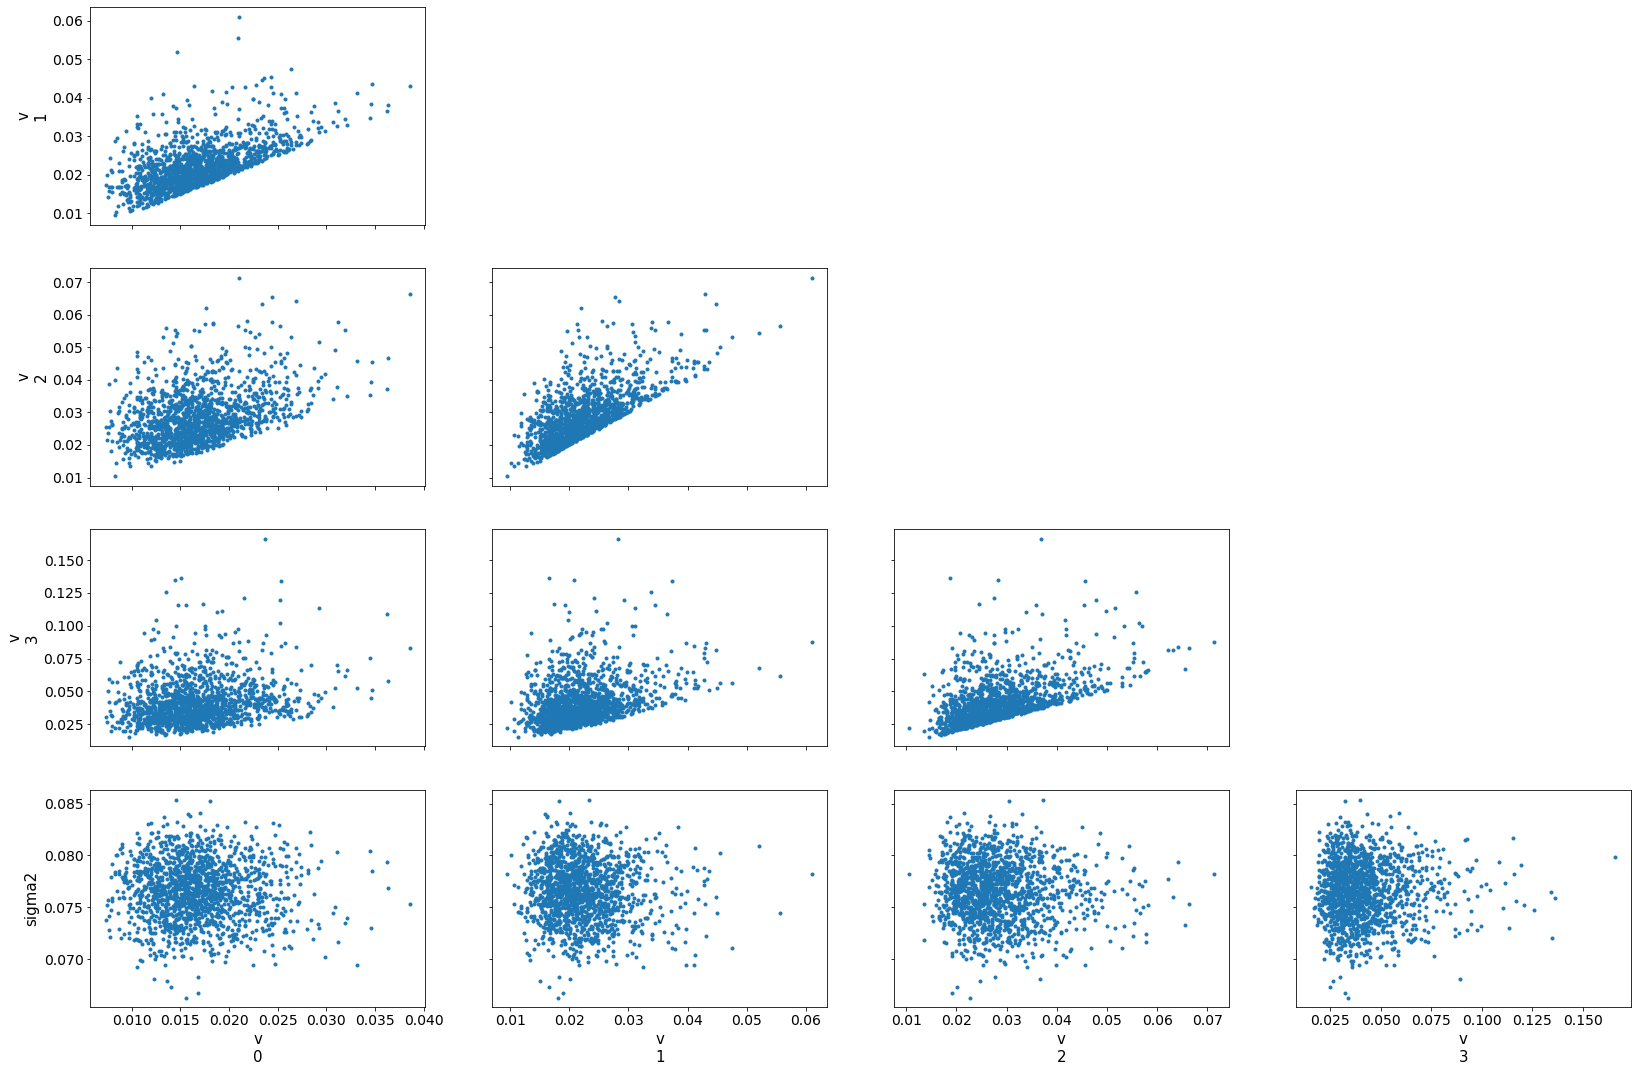

In [18]:
az_v_sigma2_plot(fit_standard)

## 4. MCMC Exact

In [19]:
ppca_dat_exact = ppca_dat_standard.copy()
ppca_dat_exact['xi']= xi

In [20]:
fit_exact = sm.sampling(data = ppca_dat_exact, iter = iterations, chains = n_chains, init = init_list,  seed =1)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [21]:
v_star_list

array([0.15893098])

In [22]:
sigma2_star

0.009702470877229528

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
v[0]    0.017  0.005   0.009    0.026      0.000    0.000    1168.0  1043.0   
v[1]    0.023  0.006   0.013    0.033      0.000    0.000    1490.0  1308.0   
v[2]    0.029  0.008   0.016    0.044      0.000    0.000    1316.0  1316.0   
v[3]    0.043  0.018   0.020    0.074      0.000    0.000    1613.0  1292.0   
sigma2  0.073  0.007   0.059    0.086      0.000    0.000    1486.0  1457.0   
W[0,0]  0.003  0.083  -0.153    0.152      0.002    0.002    1137.0  1137.0   
W[0,1]  0.000  0.069  -0.125    0.129      0.002    0.001    1143.0  1143.0   
W[0,2]  0.004  0.090  -0.147    0.181      0.003    0.002    1041.0  1041.0   
W[0,3] -0.001  0.066  -0.135    0.108      0.002    0.001    1725.0   976.0   
W[0,4]  0.006  0.076  -0.136    0.138      0.002    0.002    1339.0  1117.0   
W[1,0] -0.001  0.082  -0.137    0.163      0.002    0.002    1088.0  1088.0   
W[1,1] -0.003  0.075  -0.138    0.132      0.002    

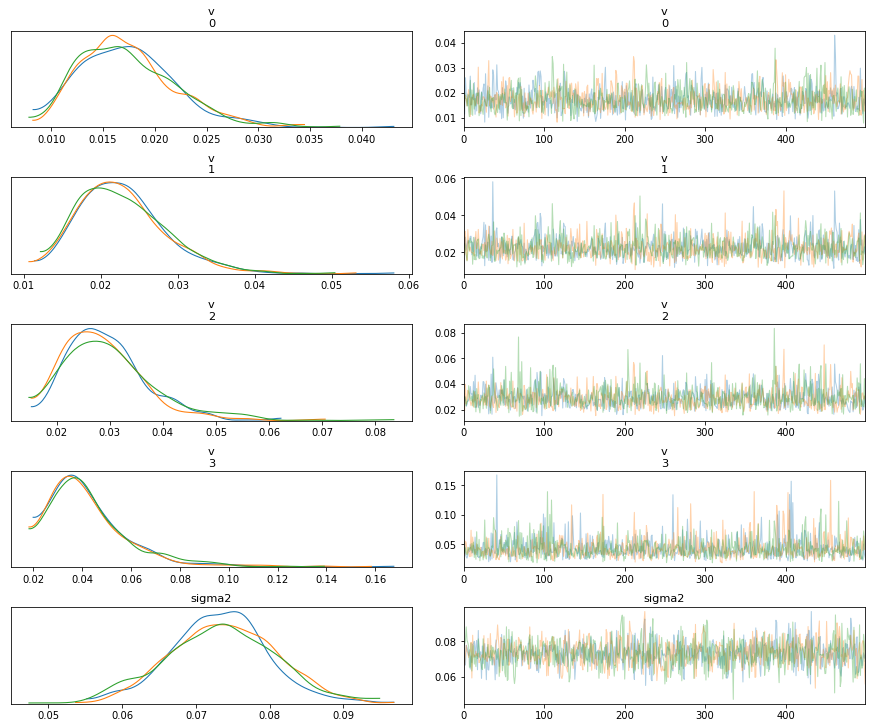

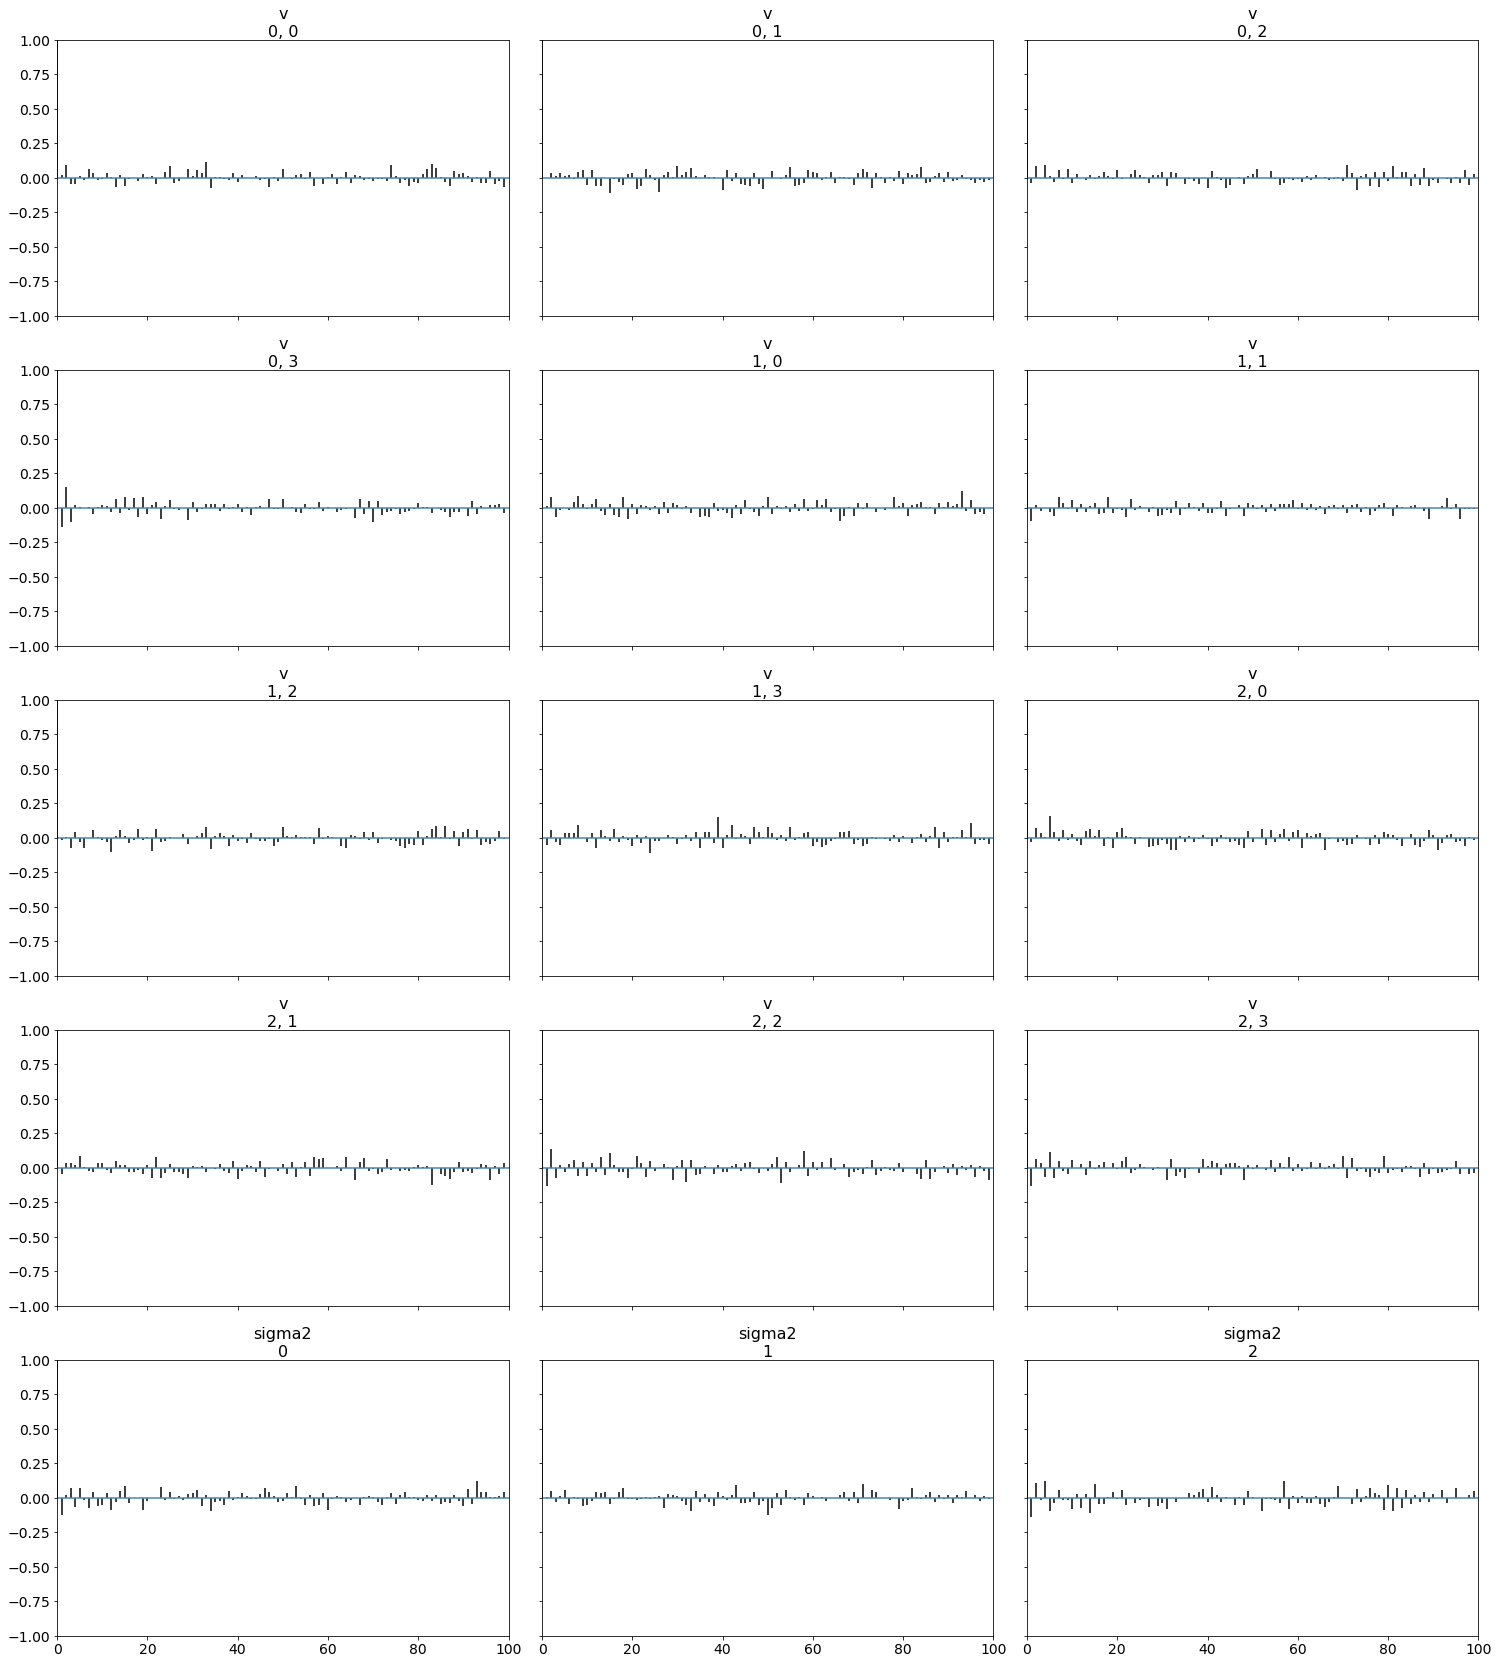

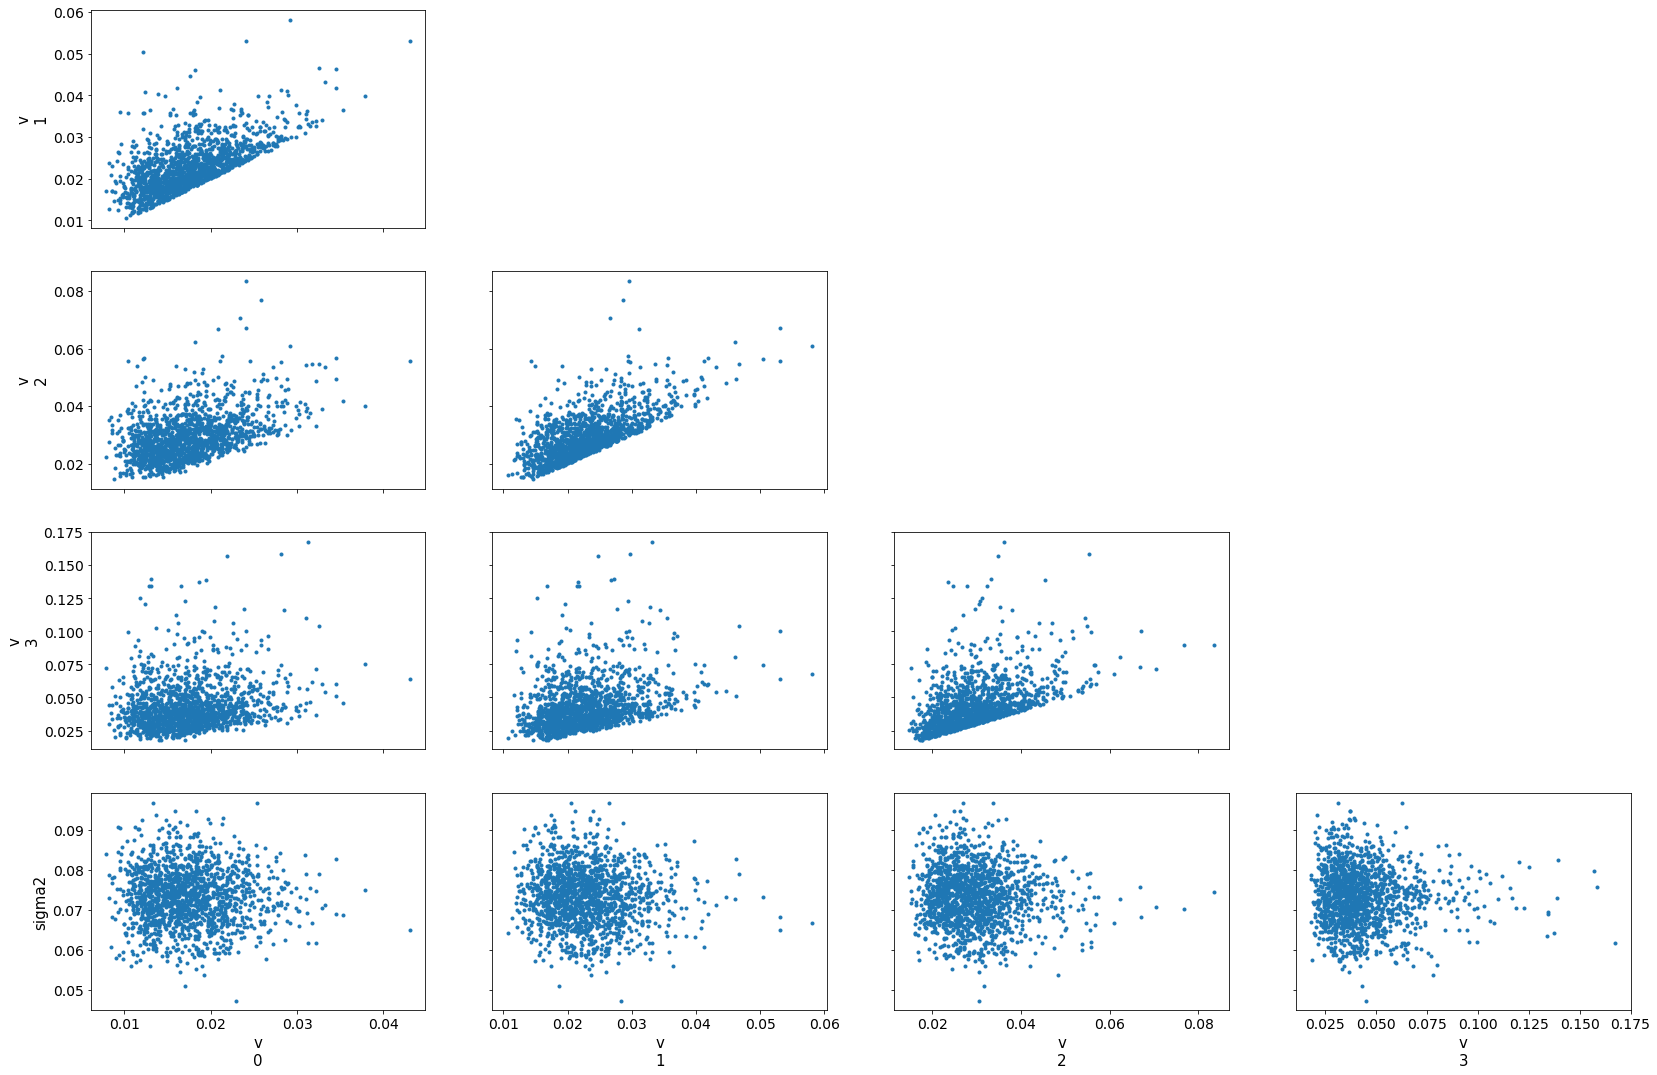

In [23]:
az_v_sigma2_plot(fit_exact)

In [24]:
print(mcmc_setup)

{'q': '4', 'xi': '0.1', 'iterations': '1000', 'n_chains': '3', 'a_sigma2': '3', 'beta_sigma2': '0.02', 'a_vj': '3.5', 'epsilon': '0.05'}


In [25]:
print(data_config)

{'d': '5', 'q_star': '1', 'n_sample': '1000', 'a_sigma2': '3', 'beta_sigma2': '0.02', 'alpha': '500', 'a_vj': '3.5', 'epsilon': '0.5'}
